# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.contrib.layers import flatten
import matplotlib.gridspec as gridspec
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import time
import cv2
import os

%matplotlib inline

In [2]:
label_names = {}
with open("signnames.csv", mode='r') as f:
    for line in f:
        splits = line.strip().split(',')
        if splits[0] == 'ClassId':
            continue
        label_names[int(splits[0])] = splits[1]
        
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

train_features, train_labels = train['features'], train['labels']
test_features, test_labels = test['features'], test['labels']

In [3]:
### Basic Data Summary

# Number of training examples
ntrain_examples = train_features.shape[0]

# Number of testing examples
ntest_examples = test_features.shape[0]

# Image Shape
image_shape = train_features.shape[1]

# Number of Label Varieties in Training Set
nclasses = 43

print("Number of Training Samples =", ntrain_examples)
print("Number of Test Samples =", ntest_examples)
print("Image Shape (Expecting 32x32) =", image_shape)
print("Label Varieties =", nclasses)

Number of Training Samples = 39209
Number of Test Samples = 12630
Image Shape (Expecting 32x32) = 32
Label Varieties = 43


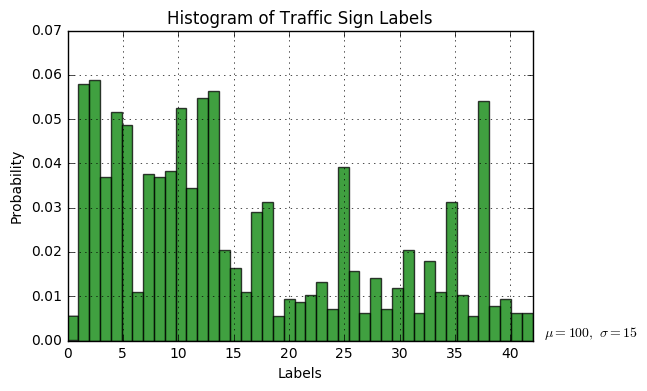

Label Name for #0 is Speed limit (20km/h)
Label Name for #1 is Speed limit (30km/h)
Label Name for #2 is Speed limit (50km/h)
Label Name for #3 is Speed limit (60km/h)
Label Name for #4 is Speed limit (70km/h)
Label Name for #5 is Speed limit (80km/h)
Label Name for #6 is End of speed limit (80km/h)
Label Name for #7 is Speed limit (100km/h)
Label Name for #8 is Speed limit (120km/h)
Label Name for #9 is No passing
Label Name for #10 is No passing for vechiles over 3.5 metric tons
Label Name for #11 is Right-of-way at the next intersection
Label Name for #12 is Priority road
Label Name for #13 is Yield
Label Name for #14 is Stop
Label Name for #15 is No vechiles
Label Name for #16 is Vechiles over 3.5 metric tons prohibited
Label Name for #17 is No entry
Label Name for #18 is General caution
Label Name for #19 is Dangerous curve to the left
Label Name for #20 is Dangerous curve to the right
Label Name for #21 is Double curve
Label Name for #22 is Bumpy road
Label Name for #23 is Slippe

In [4]:
# Histogram of Data
mu, sigma = 100, 15
x = mu + sigma * np.random.randn(10000)
n, bins, patches = plt.hist(train_labels, 43, normed=1, facecolor='g', alpha=0.75)

plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title('Histogram of Traffic Sign Labels')
plt.text(43, .001, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 42, 0, 0.07])
plt.grid(True)
plt.show()

label_names = {}
with open("signnames.csv", mode='r') as f:
    for line in f:
        splits = line.strip().split(',')
        if splits[0] == 'ClassId':
            continue
        label_names[int(splits[0])] = splits[1]
        
for label in range(0,43):
    print("Label Name for #" + str(label) + " is " + label_names[label])

A snapshot of single image variety in the dataset.


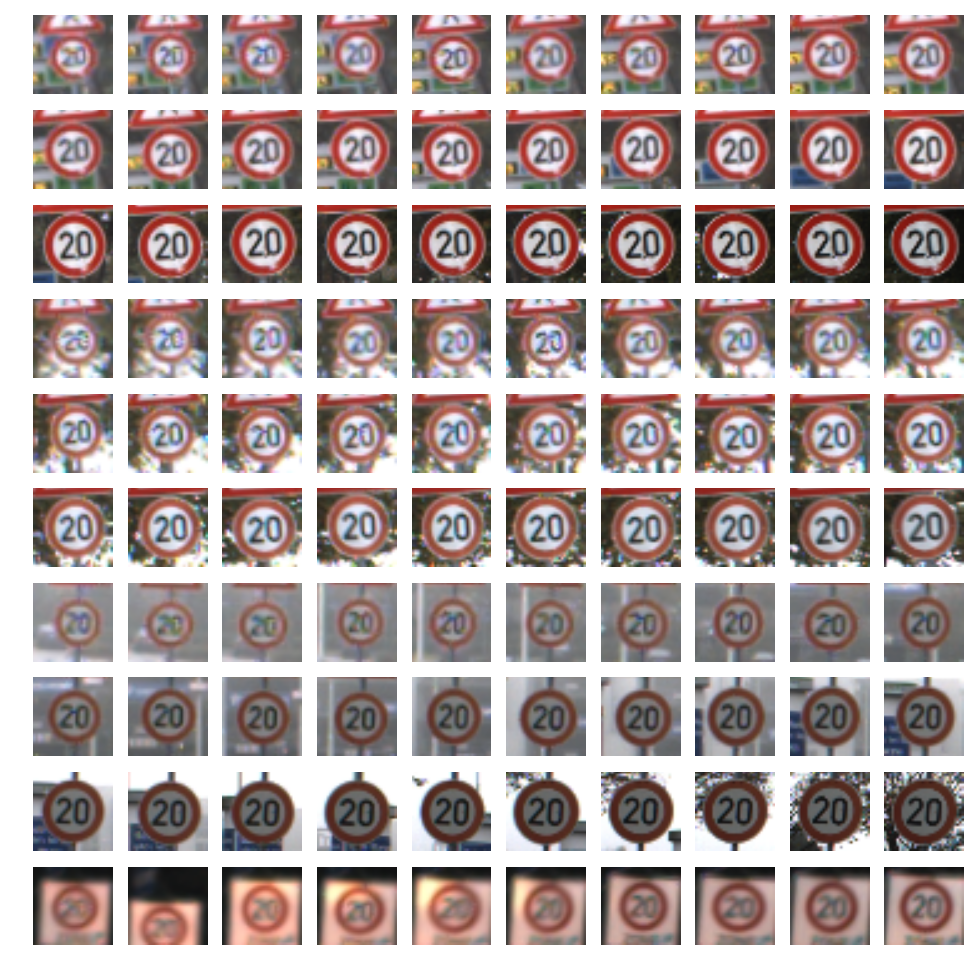

In [5]:
print("A snapshot of single image variety in the dataset.")
grid = gridspec.GridSpec(10, 10)
grid.update(wspace=0.01, hspace=0.02)
plt.figure(figsize=(12,12))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(train_features[i])
    plt.axis('off')
plt.show()

In [6]:
## This function is taken from a carnd post about jitterring an image to help imbalanced datasets.
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

Display images with a low frequency. These images will be jittered to augment the dataset.


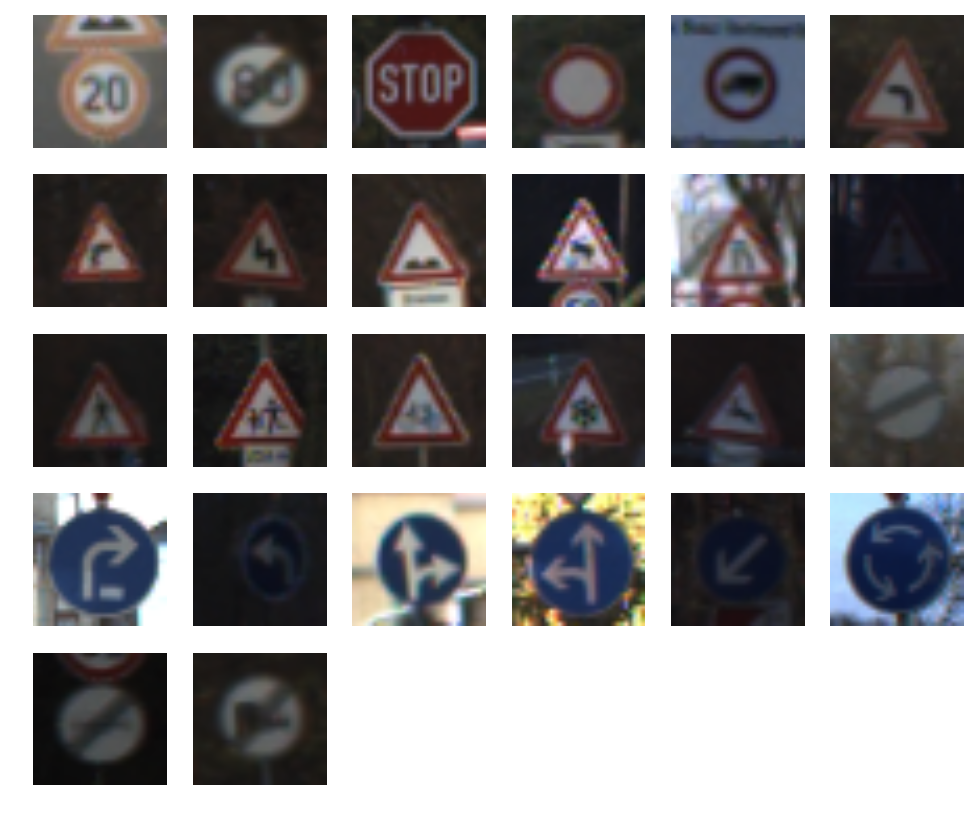

Low Frequency Images with their frequency count displayed before jittering.

210 - Speed limit (20km/h) (#0)
420 - End of speed limit (80km/h) (#6)
780 - Stop (#14)
630 - No vechiles (#15)
420 - Vechiles over 3.5 metric tons prohibited (#16)
210 - Dangerous curve to the left (#19)
360 - Dangerous curve to the right (#20)
330 - Double curve (#21)
390 - Bumpy road (#22)
510 - Slippery road (#23)
270 - Road narrows on the right (#24)
600 - Traffic signals (#26)
240 - Pedestrians (#27)
540 - Children crossing (#28)
270 - Bicycles crossing (#29)
450 - Beware of ice/snow (#30)
780 - Wild animals crossing (#31)
240 - End of all speed and passing limits (#32)
689 - Turn right ahead (#33)
420 - Turn left ahead (#34)
390 - Go straight or right (#36)
210 - Go straight or left (#37)
300 - Keep left (#39)
360 - Roundabout mandatory (#40)
240 - End of no passing (#41)
240 - End of no passing by vechiles over 3.5 metric tons (#42)


In [7]:
# Calculate the frequency of each image/label in the dataset
freq_image = [None] * 43
freq_count = np.zeros(43)
for i in range(0, len(train_features)):
    label_index = train_labels[i]
    freq_count[label_index] = freq_count[label_index] + 1
    if freq_count[label_index] == 161:
        freq_image[label_index] = train_features[i]

# Find the low frequency image/label data.
low_freq_image = []
low_freq_count = []
low_freq_label = []
for i in range(0, 43):
    if freq_count[i] < 1000 :
        low_freq_image.append(freq_image[i])
        low_freq_count.append(freq_count[i])
        low_freq_label.append(i)

print("Display images with a low frequency. These images will be jittered to augment the dataset.")
grid2 = gridspec.GridSpec(10, 10)
grid2.update(wspace=0.01, hspace=0.02)
plt.figure(figsize=(12,12))
for i in range(0, len(low_freq_label)):
    plt.subplot(6,6,i+1)
    plt.imshow(low_freq_image[i])
    plt.axis('off')
plt.show()

print("Low Frequency Images with their frequency count displayed before jittering.")
print("")
for i in range(0, len(low_freq_label)):
    print(str(int(low_freq_count[i])) + " - " + label_names[low_freq_label[i]] + " (#" + str(low_freq_label[i]) + ")")


In [8]:
ang_range = 20
shear_range = 10
trans_range = 5

train_features = list(train_features)
train_labels = list(train_labels)

In [9]:
print("Number of Training Samples BEFORE Jittering =", len(train_features))

print("Begin jittering images with low frequency in data set.")
for i in range(0, len(low_freq_label)):
    image = low_freq_image[i]
    label = low_freq_label[i]
    print("Jittering " + label_names[label])
    for j in range(100):
        img = transform_image(image, ang_range, shear_range, trans_range)
        train_features.append(img)
        train_labels.append(label)
        
print("Number of Training Samples AFTER Jittering =", len(train_features))

Number of Training Samples BEFORE Jittering = 39209
Begin jittering images with low frequency in data set.
Jittering Speed limit (20km/h)
Jittering End of speed limit (80km/h)
Jittering Stop
Jittering No vechiles
Jittering Vechiles over 3.5 metric tons prohibited
Jittering Dangerous curve to the left
Jittering Dangerous curve to the right
Jittering Double curve
Jittering Bumpy road
Jittering Slippery road
Jittering Road narrows on the right
Jittering Traffic signals
Jittering Pedestrians
Jittering Children crossing
Jittering Bicycles crossing
Jittering Beware of ice/snow
Jittering Wild animals crossing
Jittering End of all speed and passing limits
Jittering Turn right ahead
Jittering Turn left ahead
Jittering Go straight or right
Jittering Go straight or left
Jittering Keep left
Jittering Roundabout mandatory
Jittering End of no passing
Jittering End of no passing by vechiles over 3.5 metric tons
Number of Training Samples AFTER Jittering = 41809


In [10]:
print("Begin shuffling data. First label is", label_names[train_labels[0]])

def shuffle(features, labels):
    indices = np.arange(0, len(features))
    np.random.seed(43)
    np.random.shuffle(indices)
    return (features[indices], labels[indices])

train_features, train_labels = np.array(train_features), np.array(train_labels)
train_features, train_labels = shuffle(train_features, train_labels)
print("Shuffling data complete. First label is", label_names[train_labels[0]])

Begin shuffling data. First label is Speed limit (20km/h)
Shuffling data complete. First label is Speed limit (50km/h)


A snapshot of some of the images in the dataset after shuffling.


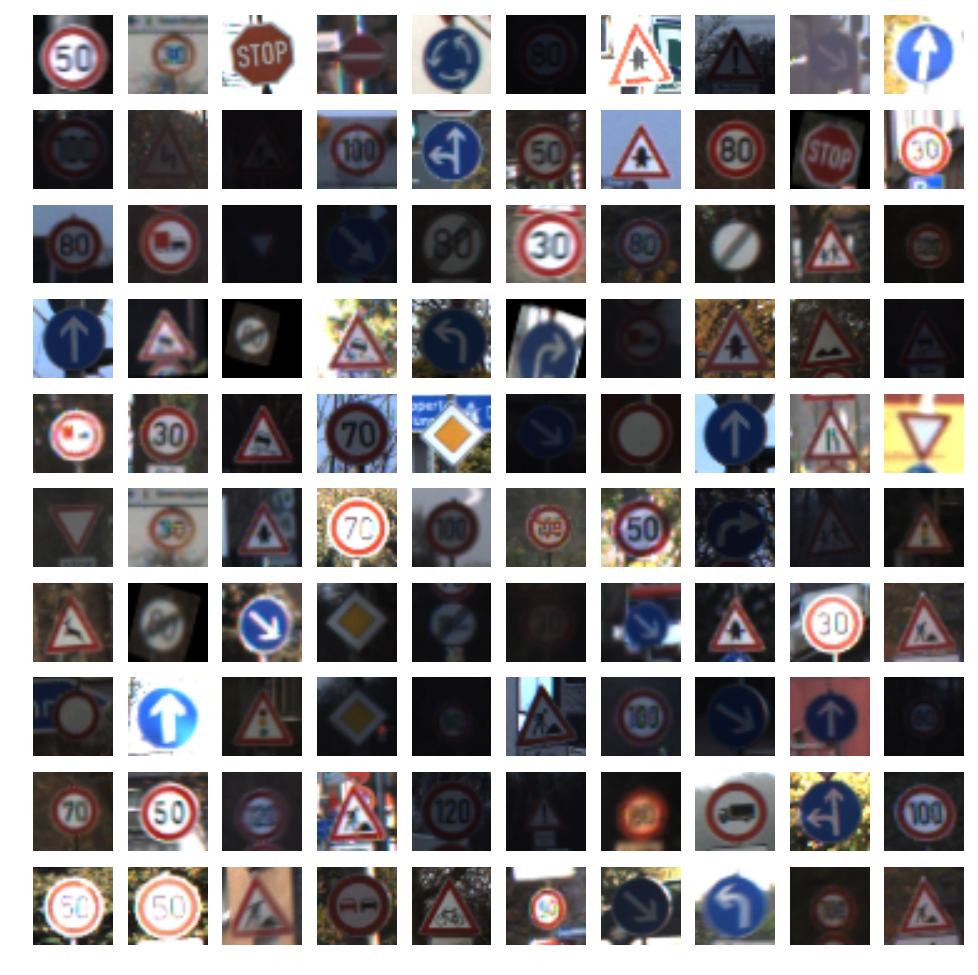

In [11]:
print("A snapshot of some of the images in the dataset after shuffling.")
grid = gridspec.GridSpec(10, 10)
grid.update(wspace=0.01, hspace=0.02)
plt.figure(figsize=(12,12))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(train_features[i])
    plt.axis('off')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [12]:
def batch(current, features, labels):
    start = current*batch_size
    end = start+batch_size
    return features[start:end], labels[start:end]

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(input=x, filter=W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return x

def maxpool2d(x, k=2):
    x = tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
    return tf.nn.relu(x)

def flat2d(x):
    return tf.reshape(x, [-1, x.get_shape()[1:4].num_elements()])

def connect2d(x, W, b):
    x = tf.matmul(x, W) + b
    return tf.nn.relu(x)

def conv_net(x, weights, biases):
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    conv1 = maxpool2d(conv1)

    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    #conv2 = maxpool2d(conv2)
    conv2 = tf.nn.relu(conv2)

    conv3 = flat2d(conv2)

    conv4 = connect2d(conv3, weights['layer_3'], biases['layer_3'])
    conv5 = connect2d(conv4, weights['layer_4'], biases['layer_4'])

    return conv5

def ohe_labels(labels):
    ohc_scheme = OneHotEncoder().fit(np.arange(nclasses).reshape(-1, 1))
    return ohc_scheme.transform(labels.reshape(-1, 1)).toarray()

## This function is taken from a carnd post about jitterring an image to help imbalanced datasets.
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    return img


In [20]:
epochs = 100
batch_size = 128
validation_size=5000
learning_rate=0.000031

num_classes = nclasses
save_file = 'model.ckpt'

layer_width = {
    'layer_1': 16,
    'layer_2': 36,
    'layer_3': 128
}

weights = {
    'layer_1': tf.Variable(tf.truncated_normal([3, 3, 1, layer_width['layer_1']], stddev=0.05)),
    'layer_2': tf.Variable(tf.truncated_normal([3, 3, layer_width['layer_1'], layer_width['layer_2']], stddev=0.05)),
    'layer_3': tf.Variable(tf.truncated_normal([9216, layer_width['layer_3']], stddev=0.05)),
    'layer_4': tf.Variable(tf.truncated_normal([layer_width['layer_3'], nclasses], stddev=0.05))
}

biases = {
    'layer_1': tf.Variable(tf.constant(0.05, shape=[layer_width['layer_1']])),
    'layer_2': tf.Variable(tf.constant(0.05, shape=[layer_width['layer_2']])),
    'layer_3': tf.Variable(tf.constant(0.05, shape=[layer_width['layer_3']])),
    'layer_4': tf.Variable(tf.constant(0.05, shape=[nclasses]))
}

In [21]:
train_features, train_labels = train_features, ohe_labels(train_labels)
test_features, test_labels = test['features'], ohe_labels(test['labels'])

train_features, train_labels = shuffle(train_features, train_labels)
test_features, test_labels = shuffle(test_features, test_labels)

validation_features = train_features[:validation_size]
validation_labels = train_labels[:validation_size]

train_features = train_features[validation_size:]
train_labels = train_labels[validation_size:]

In [22]:
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='x') / 255.
grayed = tf.image.rgb_to_grayscale(x, name='grayscale')

y = tf.placeholder(tf.float32, shape=[None, nclasses], name='y_true')
y_max = tf.argmax(y, dimension=1)

logits = conv_net(grayed, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(logits), dimension=1), y_max)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.initialize_all_variables())

    steps = len(train_features)//batch_size
    vsteps = len(validation_features)//batch_size
    tsteps = len(test_features)//batch_size

    # Training cycle
    for i in range(epochs):

        # Loop over all batches
        for step in range(steps):
            batch_x, batch_y = batch(step, train_features, train_labels)
            loss = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})

        # Only print every 5th Epoch so the console isn't cluttered. 
        if i % 5 == 0:
            validation_accuracy, validation_loss = 0, 0
            for step in range(vsteps):
                batch_vx, batch_vy = batch(step, validation_features, validation_labels)
                vloss, vacc = sess.run([cost, accuracy], feed_dict={x: batch_vx, y: batch_vy})
                validation_accuracy += (vacc * batch_vx.shape[0])
                validation_loss += (vloss * batch_vx.shape[0])

            validation_loss, validation_accuracy = validation_loss / (vsteps * batch_size), 100. * validation_accuracy / (vsteps * batch_size)
            print("Epoch: " + str(i) + " Validation Set:   Loss = " + str(validation_loss) + "   Accuracy = " + str(validation_accuracy) + "%")

    # Calculate test accuracy.
    test_accuracy, test_loss = 0, 0
    for step in range(tsteps):
        batch_tx, batch_ty = batch(step, test_features, test_labels)
        tloss, tacc = sess.run([cost, accuracy], feed_dict={x: batch_tx, y: batch_ty})
        test_accuracy += (vacc * batch_tx.shape[0])
        test_loss += (vloss * batch_tx.shape[0])

    test_accuracy, test_loss = 100. * test_accuracy / (tsteps * batch_size), test_loss / (tsteps * batch_size)
    print("Test Set: Loss - " + str(test_loss) + "   Accuracy - " + str(test_accuracy) + "%")
    
    saver.save(sess, save_file)

Epoch: 0 Validation Set:   Loss = 0.399547201701   Accuracy = 97.8365384615%
Epoch: 5 Validation Set:   Loss = 0.229479115265   Accuracy = 97.8565705128%
Epoch: 10 Validation Set:   Loss = 0.204007479243   Accuracy = 97.8565705128%
Epoch: 15 Validation Set:   Loss = 0.199187263369   Accuracy = 97.8565705128%
Epoch: 20 Validation Set:   Loss = 0.198988654006   Accuracy = 97.8565705128%
Epoch: 25 Validation Set:   Loss = 0.20001890902   Accuracy = 97.8565705128%
Epoch: 30 Validation Set:   Loss = 0.202108129572   Accuracy = 97.8565705128%
Epoch: 35 Validation Set:   Loss = 0.204241935976   Accuracy = 97.8565705128%
Epoch: 40 Validation Set:   Loss = 0.207217654166   Accuracy = 97.8565705128%
Epoch: 45 Validation Set:   Loss = 0.210399392658   Accuracy = 97.8565705128%
Epoch: 50 Validation Set:   Loss = 0.213584246783   Accuracy = 97.8565705128%
Epoch: 55 Validation Set:   Loss = 0.217487029922   Accuracy = 97.8565705128%
Epoch: 60 Validation Set:   Loss = 0.222028145423   Accuracy = 97.8

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

To preprocess the data, I generated additional data by jittering images whose label appeared with a low frequency. I also split the training set into a training set and a validation set so I could monitor the progress of the model while training. I shuffled the feature sets since they were sorted to start with. 

Additionally, I converted the images to grayscale before passing them through the model.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I initially took the training set and generated data based on low frequency image categories and then added them back to the training set. After, I shuffled the training set and set aside the first 5000 as my validation set, using the rest as the training set.

After plotting the data, I noticed how low some of the frquency was (240 vs 2070) and thought jittering might be worth trying (to see if it boosted accuracy) and when I tried it, it did!

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My final architecture is pretty simple. Originally, I had larger larger layers (and more layers) but I found that neither increased the accuracy of my model; in most cases in fact, it made my model incredibly slow and more inaccurate.

The first layer consists of the set of weights and biases applied to a gray_scaled image and passed through relus. The output of this layer is fed to the next layer (connvolution) which uses the max activation for each channel (max pooling) and sets the corresponding channel's value to this maximum in the output before passes through relus. The third layer flattens the previous output before creating 2 fully connected layers passed through relus.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the Adam algorithm for my optimizer (AdamOptimizer) since it uses moving averages of the parameters. I brute-force tested the best learning_rate to use starting with a 0.0001 value. As for the batch size, I choose this pretty randomly. I started with a size similar to what was in the example model and played with different sizes, typing to stay with numbers that were of log 2 (i.e. 256, 512, etc). With epochs, I noticed that my accuracy/loss rate began converging around 80~ runs, so I capped the number of 100 and stayed within that range.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

This problem was honestly really hard. I originally didn't know where to start. 

First, I started with the sample CNN demoed in class using the MNIST dataset. I started with that simple structure and had a very low accuracy score so I went back to the drawing board and started trying to build a model. 

Overall, I ended up keeping the same "shape" but I had minor tweaks that made a huge difference in how I was able to solve the problem. For example, I originally used max pooling after my first 2 convolutional layers. As I was testing to see how different structures affected my model's performance, I noticed that moving the second max pooling dramatically decreased performance on the model (also realized that the second one didn't necessary make sense to have in terms of applying the max activating back to back).

I also mentioned this earlier but the size of the input layers and the number of layers I used was something I had to revisit because it my model processed too slow. Through further analysis, I realized I wasn't gaining much with larger inputs and more layers, in fact it seemed to segment the data in such a way that slowed performance.

Overall, I approached this with alot of trial and error or by taking one insight and then experimenting/testing to see how it affected the model.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [24]:
path = './'
custom_features = ['{}'.format(path)+image for image in os.listdir(path) if image.endswith('jpg') or image.endswith('png')]
label_arr = []
label_arr.append(np.array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]))
label_arr.append(np.array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]))
label_arr.append(np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]))
label_arr.append(np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]))
label_arr.append(np.array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]))
custom_labels = np.array(label_arr).reshape(5, 43)

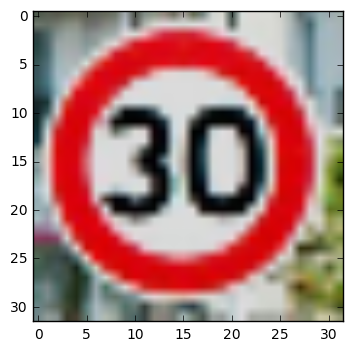

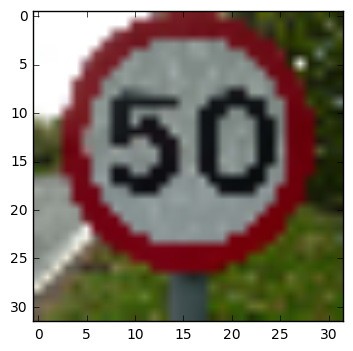

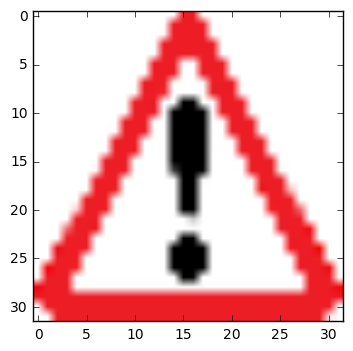

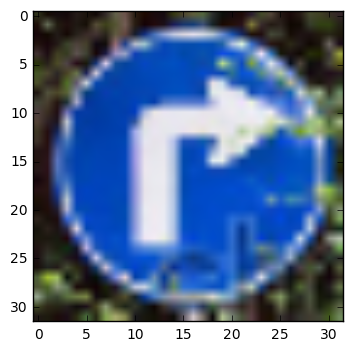

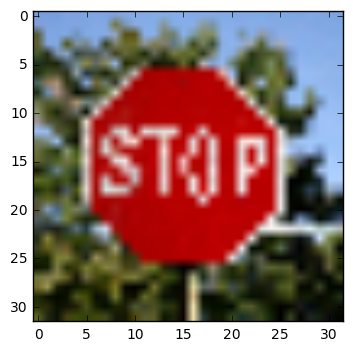

In [25]:
processed = []
for i in range(0,len(custom_features)):
    image = mpimg.imread(custom_features[i])
    image = cv2.resize(image, (32,32))
    plt.imshow(image)
    plt.show()
    processed.append(image)
custom_features = np.array(processed, dtype=np.uint8)

In [26]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_file)
    print('Trained Model Restored')
    closs, caccuracy = sess.run([cost, accuracy], feed_dict={x: custom_features, y: custom_labels})

    caccuracy = 100. * caccuracy
    print('New Image Set: Loss - ' + str(closs) + '    Accuracy: ' + str(caccuracy) + '%')

Trained Model Restored
New Image Set: Loss - 32.3372    Accuracy: 0.0%


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

Some of the images are rendered images of the road sign (white background) as opposed to a photo of the road sign taken on the street. There are differences in terms of brightness and even in choosing the images, I struggled to choose images I thought would be represented by the dataset; for example, we don't have 20km road signs where I live and that's due to the fact that we don't use km at all. Additionally, I had to crop the images before resizing them because very many of them where general landscape photos that included other unnecessary content in addition to the road sign.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

It didn't quite perform as well as the images in the training set. I'm not sure if I captured the images well or if it's the brightness in the image or something else that throws the prediction off. The accuracy is significantly lower when compared to the results of the test dataset.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

In [32]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, save_file)
    print('Trained Model Restored')
    
    correct = tf.nn.in_top_k(logits, labels, 1)

    print(correct)
    print(tf.reduce_sum(tf.cast(correct, tf.int32)))

Trained Model Restored
Tensor("InTopK_4:0", shape=(5,), dtype=bool)
Tensor("Sum_1:0", shape=(), dtype=int32)


### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.